In [13]:
from google.colab import files

uploaded = files.upload()

Saving simpan_dataset_stok_alat_sewa.csv to simpan_dataset_stok_alat_sewa (1).csv


In [14]:
import pandas as pd

# Baca file CSV
df = pd.read_csv("simpan_dataset_stok_alat_sewa.csv")

# Tampilkan beberapa baris awal
df.head()

,Tanggal,Nama Barang,Toko/Pelanggan,Jumlah
0,2024-01-01 0:00:00,"Tenda, Gas Rent",Wahyu Sukarno Putra,2.0
1,2024-01-03 0:00:00,"Tenda, Gas Tukar",Fernando Candra Raharjo,2.0
2,2024-01-03 0:00:00,"Tenda, Matras, Kompor, Lampu, Kursi",Muhammad Ikhsan,9.0
3,2024-01-05 0:00:00,"Sarung Tangan, Headlamp, Cover Bag, Sepatu",Agil Haikal,4.0
4,2024-01-07 0:00:00,"Tenda, Gas Rent",Adam Febrilino Widayat,2.0


In [15]:
# Filter hanya baris yang memiliki jumlah
df_filtered = df[df['Jumlah'].notnull()].copy()

# Bersihkan teks
df_filtered['Nama Barang'] = df_filtered['Nama Barang'].str.lower().str.strip()
df_filtered['Toko/Pelanggan'] = df_filtered['Toko/Pelanggan'].str.title().str.strip()

# Ubah tanggal jadi datetime
df_filtered['Tanggal'] = pd.to_datetime(df_filtered['Tanggal'], errors='coerce')

# Pecah nama barang menjadi beberapa baris
df_filtered['Nama Barang'] = df_filtered['Nama Barang'].str.split(', ')
df_exploded = df_filtered.explode('Nama Barang').reset_index(drop=True)

df_exploded.head()

,Tanggal,Nama Barang,Toko/Pelanggan,Jumlah
0,2024-01-01,tenda,Wahyu Sukarno Putra,2.0
1,2024-01-01,gas rent,Wahyu Sukarno Putra,2.0
2,2024-01-03,tenda,Fernando Candra Raharjo,2.0
3,2024-01-03,gas tukar,Fernando Candra Raharjo,2.0
4,2024-01-03,tenda,Muhammad Ikhsan,9.0


In [16]:
from sklearn.preprocessing import LabelEncoder

# Fitur waktu (opsional)
df_exploded['Bulan'] = df_exploded['Tanggal'].dt.month

# Encoding nama barang dan toko
le_barang = LabelEncoder()
le_toko = LabelEncoder()

df_exploded['Barang_Encoded'] = le_barang.fit_transform(df_exploded['Nama Barang'])
df_exploded['Toko_Encoded'] = le_toko.fit_transform(df_exploded['Toko/Pelanggan'])

# Fitur dan label
X = df_exploded[['Barang_Encoded', 'Toko_Encoded', 'Bulan']]
y = df_exploded['Jumlah']

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model prediksi
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Evaluasi
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("MSE:", mse)

MSE: 14.95890410958904


In [18]:
def kategorikan(jumlah):
    if jumlah <= 2:
        return 'Rendah'
    elif jumlah <= 6:
        return 'Sedang'
    else:
        return 'Tinggi'

df_exploded['Kategori_Jumlah'] = df_exploded['Jumlah'].apply(kategorikan)

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Fitur dan label
X_cls = df_exploded[['Barang_Encoded', 'Toko_Encoded', 'Bulan']]
y_cls = df_exploded['Kategori_Jumlah']

# Encode label kategori
from sklearn.preprocessing import LabelEncoder
le_kat = LabelEncoder()
y_cls_encoded = le_kat.fit_transform(y_cls)

# Split data
X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_cls_encoded, test_size=0.2, random_state=42)

# Model Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_cls, y_train_cls)

# Evaluasi
y_pred_cls = nb_model.predict(X_test_cls)
print(classification_report(y_test_cls, y_pred_cls, target_names=le_kat.classes_))

              precision    recall  f1-score   support

      Rendah       0.00      0.00      0.00        13
      Sedang       0.31      0.56      0.40        18
      Tinggi       0.61      0.55      0.57        42

    accuracy                           0.45        73
   macro avg       0.31      0.37      0.33        73
weighted avg       0.43      0.45      0.43        73



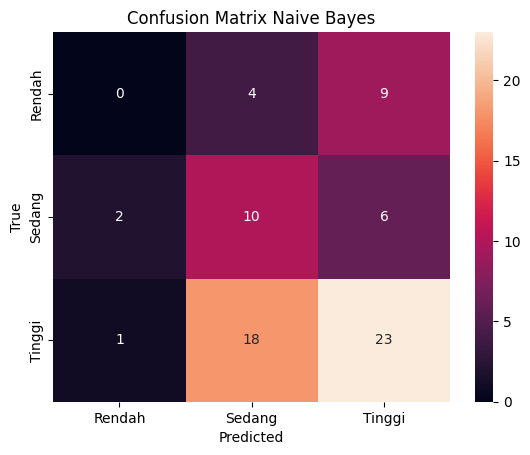

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_cls, y_pred_cls)
sns.heatmap(cm, annot=True, xticklabels=le_kat.classes_, yticklabels=le_kat.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Naive Bayes')
plt.show()